In [1]:
#default_exp core

In [10]:
#export
from realtime_ptycho.util import sparse_to_dense_datacube_crop
from py4DSTEM.process.calibration import get_probe_size
import cupy as cp
import numpy as np
from skimage.filters import gaussian
import numpy as np
import numba.cuda 
from numba import jit
import h5py 
from realtime_ptycho.util import *
import cupy as cp

class Sparse4DData:
    
    def __init__(self):
        self.indices = None
        self.counts = None
        self.scan_dimensions = None 
        self.frame_dimensions = None 
    
    @staticmethod
    def from_4Dcamera_file(filename):
        with h5py.File(filename, 'r') as f0:
            frames = f0['electron_events/frames'][:]
            scan_dimensions = (f0['electron_events/scan_positions'].attrs['Ny'],
                               f0['electron_events/scan_positions'].attrs['Nx'])
            frame_dimensions = np.array((576, 576))
        
        def unragged_frames_size(frames):
            mm = 0
            for ev in frames:
                if ev.shape[0] > mm:
                    mm = ev.shape[0]
            return mm
        
        def make_unragged_frames(frames, scan_dimensions):
            unragged_frame_size = unragged_frames_size(frames.ravel())
            fr_full = cp.zeros((frames.ravel().shape[0], unragged_frame_size), dtype=cp.int32)
            fr_full[:] = cp.iinfo(fr_full.dtype).max
            for ii, ev in enumerate(frames.ravel()):
                fr_full[ii, :ev.shape[0]] = cp.array(ev)
            fr_full_4d = fr_full.reshape((*scan_dimensions, fr_full.shape[1]))
            fr_full_4d = fr_full_4d[:, :-1, :] 
            return fr_full_4d
        
        d = Sparse4DData()
        d.indices = cp.ascontiguousarray(make_unragged_frames(frames.ravel(), scan_dimensions))
        d.scan_dimensions = np.array(d.indices.shape[:2])
        d.frame_dimensions = frame_dimensions
        d.counts = cp.zeros(d.indices.shape, dtype=cp.bool)
        d.counts[d.indices != cp.iinfo(d.indices.dtype).max] = 1
        
        return d 
    
    def crop_symmetric_center_(self, center, max_radius = None):
        if max_radius is None:
            y_min_radius = np.min([center[0], self.frame_dimensions[0] - center[0]])
            x_min_radius = np.min([center[1], self.frame_dimensions[1] - center[1]])
            max_radius = np.min([y_min_radius, x_min_radius])
        new_frames, new_frame_dimensions = crop_symmetric_around_center(self.indices,
                                                                        self.frame_dimensions,
                                                                        center, max_radius)
        print(f'old frames frame_dimensions: {self.frame_dimensions}')
        print(f'new frames frame_dimensions: {new_frame_dimensions}')
        self.indices = new_frames
        self.counts = cp.zeros(self.indices.shape, dtype=cp.bool)
        self.counts[self.indices != cp.iinfo(self.indices.dtype).max] = 1
        self.frame_dimensions = new_frame_dimensions
        
    def crop_symmetric_center(self, center, max_radius = None):
        if max_radius is None:
            y_min_radius = np.min([center[0], self.frame_dimensions[0] - center[0]])
            x_min_radius = np.min([center[1], self.frame_dimensions[1] - center[1]])
            max_radius = np.min([y_min_radius, x_min_radius])
        new_frames, new_frame_dimensions = crop_symmetric_around_center(cp.array(self.indices),
                                                                        cp.array(self.frame_dimensions),
                                                                        center, max_radius)
        print(f'old frames frame_dimensions: {self.frame_dimensions}')
        print(f'new frames frame_dimensions: {new_frame_dimensions}')
        res = Sparse4DData()
        res.indices = new_frames
        res.counts = cp.zeros(self.indices.shape, dtype=cp.bool)
        res.counts[self.indices != cp.iinfo(self.indices.dtype).max] = 1
        res.frame_dimensions = new_frame_dimensions
        res.scan_dimensions = self.scan_dimensions.copy()
        return res
    
    def rotate_(self, angle_rad, center=None):
        if center is None:
            center = self.frame_dimensions // 2
        new_indices = rotate(self.indices, self.frame_dimensions, center, angle_rad)
        self.indices = new_indices
    
    def rotate(self, angle_rad, center=None):
        if center is None:
            center = self.frame_dimensions // 2
        new_indices = rotate(self.indices, self.frame_dimensions, center, angle_rad)
        res = Sparse4DData()
        res.indices = new_indices
        res.counts = self.counts.copy()
        res.frame_dimensions = self.frame_dimensions
        res.scan_dimensions = self.scan_dimensions.copy()
        return res 
    
    def sum_diffraction(self):
        res = sum_frames(self.indices, self.counts, self.frame_dimensions)
        return res 
    
    @staticmethod
    def _determine_center_and_radius(data , manual=False, size=25):
        sh = np.concatenate([data.scan_dimensions,data.frame_dimensions])
        c = np.zeros((2,))
        c[:] = (sh[-1] // 2, sh[-2] // 2)
        c = cp.array(c)
        radius = cp.ones((1,)) * sh[-1] // 2  
        inds = cp.array(data.indices[:size, :size].astype(cp.uint32))
        cts = cp.array(data.counts[:size, :size].astype(cp.uint32))
        dc_subset = sparse_to_dense_datacube_crop(inds,cts, (size,size), data.frame_dimensions, c, radius, bin=2)
        dcs = cp.sum(dc_subset, (0, 1))
        m1 = dcs.get()
        m = (gaussian(m1.astype(cp.float32),2) > m1.max() * 3e-1).astype(cp.float)
        r, y0, x0 = get_probe_size(m)
        return 2 * np.array([y0,x0]), r*2
    
    def determine_center_and_radius(self, manual=False, size=25):
        return Sparse4DData._determine_center_and_radius(self, manual, size=size)
    
    def to_dense(self, bin_factor):
        dense = sparse_to_dense_datacube_crop_gain_mask(self.indices, self.counts.astype(cp.int16), self.scan_dimensions,
                                                self.frame_dimensions, self.frame_dimensions/2, self.frame_dimensions[0]/2,
                                                self.frame_dimensions[0]/2, binning=bin_factor, fftshift=False)
        return dense
    
    @staticmethod
    def from_dense(dense, make_float = False):
        res = Sparse4DData()
        res.frame_dimensions = np.array(dense.shape[-2:])
        res.scan_dimensions = np.array(dense.shape[:2])

        inds = np.prod(res.frame_dimensions)
        if inds > 2**31:
            dtype = cp.int64
        elif inds > 2**15:
            dtype = cp.int32
        elif inds > 2**8:
            dtype = cp.int16
        else:
            dtype = cp.uint8
        
        nonzeros = cp.sum((dense > 0),(2,3))
        nonzeros = cp.max(nonzeros)

        bits_counts = np.log2(dense.max())
        if make_float:
            dtype_counts = cp.float32
        else:
            if bits_counts > np.log2(2**31-1):
                dtype_counts = cp.int64
            elif bits_counts > np.log2(2**15-1):
                dtype_counts = cp.int32
            elif bits_counts > 8:
                dtype_counts = cp.int16
            else:
                dtype_counts = cp.uint8

        threadsperblock = (16, 16)
        blockspergrid = tuple(np.ceil(res.scan_dimensions / threadsperblock).astype(np.int))
        dense = cp.array(dense)
        indices = cp.zeros((*dense.shape[:2], nonzeros), dtype=dtype)
        indices[:] = cp.iinfo(dtype).max
        counts = cp.zeros((*dense.shape[:2], nonzeros), dtype=dtype_counts)
        dense_to_sparse_kernel[blockspergrid, threadsperblock](dense, indices, counts, cp.array(res.frame_dimensions))

        res.indices = indices.get()
        res.counts = counts.get()
        
        print(f'frame_dimensions: {res.frame_dimensions}')
        print(f'scan_dimensions : {res.scan_dimensions}')
        print(f'Using dtype: {dtype} for indices')
        print(f'Using dtype: {dtype_counts} for counts')
        return res
    
    @staticmethod
    def rebin(sparse_data, bin_factor : int):
        dense = sparse_to_dense_datacube_crop_gain_mask(sparse_data.indices, sparse_data.counts.astype(cp.int16), sparse_data.scan_dimensions, 
                                                sparse_data.frame_dimensions, sparse_data.frame_dimensions/2, sparse_data.frame_dimensions[0]/2,
                                                sparse_data.frame_dimensions[0]/2, binning=bin_factor, fftshift=False)
        sparse = Sparse4DData.from_dense(dense)
        return sparse
    
    @staticmethod
    def fftshift(sparse_data):
        indices = sparse_data.indices
        scan_dimensions = sparse_data.scan_dimensions
        frame_dimensions = sparse_data.frame_dimensions
        center_frame = frame_dimensions / 2
        radius_data = frame_dimensions[0] / 2
        
        threadsperblock = (16, 16)
        blockspergrid = tuple(np.ceil(np.array(indices.shape[:2]) / threadsperblock).astype(np.int))
    
        no_count_indicator = np.iinfo(indices.dtype).max
        inds = cp.array(indices)
        fftshift_kernel[blockspergrid, threadsperblock](inds, center_frame, scan_dimensions, no_count_indicator)
        sparse_data.indices = inds.get()
        return sparse_data
    
    @staticmethod
    def fftshift_and_pad_to(sparse_data, pad_to_frame_dimensions):
        indices = sparse_data.indices
        scan_dimensions = sparse_data.scan_dimensions
        frame_dimensions = sparse_data.frame_dimensions
        center_frame = frame_dimensions / 2

        threadsperblock = (16, 16)
        blockspergrid = tuple(np.ceil(np.array(indices.shape[:2]) / threadsperblock).astype(np.int))

        no_count_indicator_old = np.iinfo(indices.dtype).max

        inds = np.prod(pad_to_frame_dimensions)
        if inds > 2**15:
            dtype = cp.int64
        elif inds > 2**15:
            dtype = cp.int32
        elif inds > 2**8:
            dtype = cp.int16
        else:
            dtype = cp.uint8

        no_count_indicator_new = cp.iinfo(dtype).max

        inds = cp.array(indices, dtype=dtype)
        fftshift_pad_kernel[blockspergrid, threadsperblock](inds, center_frame, scan_dimensions, 
                                                            cp.array(pad_to_frame_dimensions), no_count_indicator_old, 
                                                            no_count_indicator_new)
        sparse_data.indices = inds.get()
        sparse_data.frame_dimensions = np.array(pad_to_frame_dimensions)
        return sparse_data
    
    def fftshift_(self):
        return Sparse4DData.fftshift(self)
    
    def fftshift_and_pad_to_(self, pad_to_frame_dimensions):
        return Sparse4DData.fftshift_and_pad_to(self, pad_to_frame_dimensions)
    
    def bin(self, binning_factor):
        res = Sparse4DData.rebin(self, binning_factor)                
        return res 
    
    def virtual_annular_image(self, inner_radius, outer_radius, center):
        img = cp.zeros(tuple(self.scan_dimensions), dtype=np.uint32)
        no_count_indicator = np.iinfo(self.indices.dtype).max
        threadsperblock = (16, 16)
        blockspergrid = tuple(np.ceil(np.array(self.indices.shape[:2]) / threadsperblock).astype(np.int))
        virtual_annular_image_kernel[blockspergrid, threadsperblock](img, cp.array(self.indices), cp.array(self.counts.astype(np.uint32)),
                                                                     inner_radius, outer_radius, cp.array(center), 
                                                                     cp.array(self.frame_dimensions), no_count_indicator)
        return img.get()
    
    def fluence(self, dr):
        sum_electrons = self.counts.sum()
        area = np.prod(self.scan_dimensions) * dr**2
        return sum_electrons/area

    def flux(self, dr, dwell_time):
        fluence = self.fluence(dr)
        flux = fluence / (np.prod(self.scan_dimensions) * dwell_time)
        return flux 
    
    def slice(self, slice):
        res = Sparse4DData()
        res.indices = cp.ascontiguousarray(self.indices[slice]) 
        res.counts = cp.ascontiguousarray(self.counts[slice])
        res.scan_dimensions = np.array(res.counts.shape[:2])
        res.frame_dimensions = self.frame_dimensions.copy()     
        return res 
    
    def center_of_mass(self):
        qx, qy = np.meshgrid(np.arange(self.scan_dimensions[0]),np.arange(self.scan_dimensions[1]))    
        comx = cp.zeros(self.scan_dimensions, dtype=cp.float32)
        comy = cp.zeros(self.scan_dimensions, dtype=cp.float32)
        
        no_count_indicator = np.iinfo(self.indices.dtype).max
        
        mass = cp.sum(self.counts,2)
        
        threadsperblock = (16, 16)
        blockspergrid = tuple(np.ceil(np.array(self.indices.shape[:2]) / threadsperblock).astype(np.int))
        
        qx = cp.array(qx).astype(cp.float32)
        qy = cp.array(qy).astype(cp.float32)
        center_of_mass_kernel[blockspergrid, threadsperblock](comx, comy, self.indices, self.counts.astype(cp.uint32), 
                                                              cp.array(self.frame_dimensions), no_count_indicator, qx, qy)
        comy = comy 
        comx = comx 
        comx /= mass + 1e-6
        comy /= mass + 1e-6
        comy[comy==0] = cp.mean(comy[comy!=0])
        comx[comx==0] = cp.mean(comx[comx!=0])
        comx -= cp.mean(comx)
        comy -= cp.mean(comy)
        return comy, comx

In [1]:
# import smatrix as sm
# from smatrix.core import Sparse4DData
# from numpy.fft import fftshift, fft2
# import cupy as cp
# 
# # mempool = cp.get_default_memory_pool()
# # x = cp.array((mempool.total_bytes(),), dtype=cp.uint8)
# # del x
# 
# filename = '/home/philipp/nvme/2020-09-22/4d/data_scan160_th4.0_electrons.h5'
# d = Sparse4DData.from_4Dcamera_file(filename)
# 

In [2]:
# center, radius = d.determine_center_and_radius(manual=False) 
# 

In [3]:
# d.crop_symmetric_center_(center)
# 

old frames shape: (512, 512, 2029)
new frames shape: (512, 512, 2029)
old frames frame_dimensions: [576 576]
new frames frame_dimensions: [342 342]


In [4]:
# mempool = cp.get_default_memory_pool()
# print(mempool.used_bytes())              # 0
# print(mempool.total_bytes())             # 0
# mempool.free_all_blocks()
# 

0
7224922624


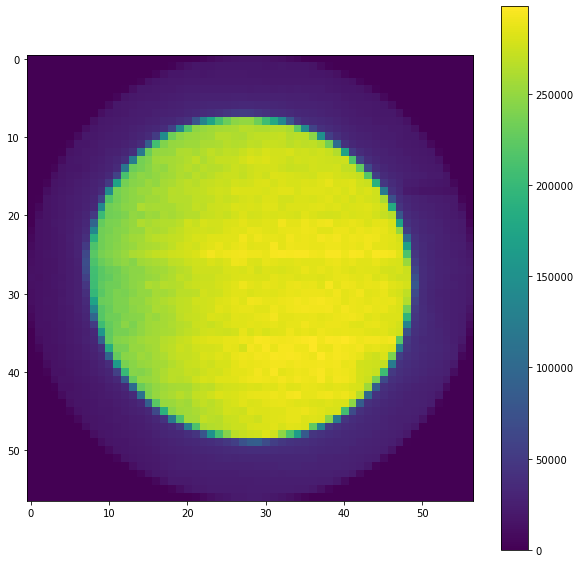

In [5]:
# s = d.sum_diffraction()
# 
# def rebin(arr, new_shape):
#     shape = (new_shape[0], arr.shape[0] // new_shape[0],
#              new_shape[1], arr.shape[1] // new_shape[1])
#     return arr.reshape(shape).sum(-1).sum(1)
# f,ax = plt.subplots(figsize=(10,10))
# s = rebin(s,np.array(s.shape)//6)
# s1 = np.abs(fftshift(fft2(s)))
# imax = ax.imshow(s)
# plt.colorbar(imax)
# 

In [6]:
# mempool = cp.get_default_memory_pool()
# print(mempool.used_bytes())              # 0
# print(mempool.total_bytes())             # 0
# 

0
936448


radius_data_int : 174 
radius_max_int  : 174 
Dense frame size: 58x 58
[29 29]
Using sparse dtype: <class 'numpy.uint16'>


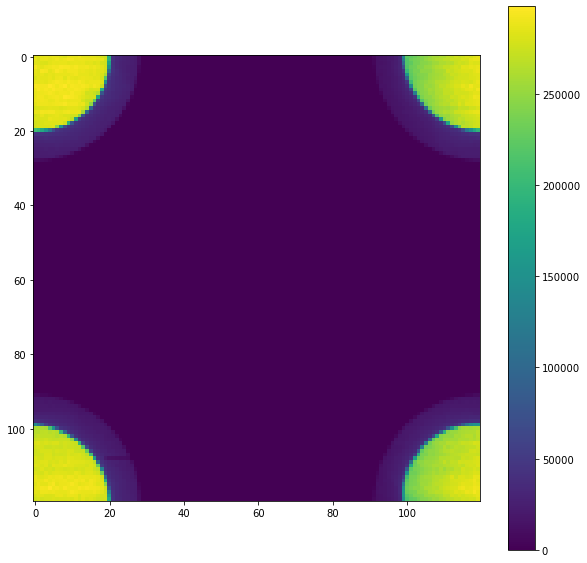

In [8]:
# sparse_data = d.bin(6)
# 
# 
# f,ax = plt.subplots(figsize=(10,10))
# sparse_data.fftshift_and_pad_to_((120,120))
# s = sparse_data.sum_diffraction()
# imax = ax.imshow(s)
# plt.colorbar(imax)
# 

In [ ]:
# a = np.zeros((1,), dtype=np.uint32)
# a[0] = np.iinfo(a.dtype).max
# a[0] == np.iinfo(a.dtype).max
# 

In [15]:
# 512 * 512 * 2029
# 

531890176

In [11]:
# sparse_data.frame_dimensions
# 

array([100, 100])